In [2]:
import pandas as pd
import numpy as np
import os
import mxnet as mx
import shutil

In [3]:
data_dir = "/Users/shengwan/Desktop/data"
train_dir = "train"
test_dir = "test"
train_gy_dir = "train_gy"
test_gy_dir = "test_gy"

## Preprocess

In [5]:
# remove original directory
train_gy_path = os.path.join(data_dir, train_gy_dir)
if os.path.exists(train_gy_path):
    shutil.rmtree(train_gy_path)
    
# make new directory
if not os.path.exists(train_gy_path):
    os.makedirs(train_gy_path)
    
# get training data id and labels
id_labels = pd.read_csv(os.path.join(data_dir, "labels.csv"))

# construct sym link between train_dir and train_gy_dir
for _, (curr_id, curr_breed) in id_labels.iterrows():
    dst_dir = os.path.join(train_gy_path, curr_breed)
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    src_loc = os.path.join(data_dir, train_dir, curr_id+".jpg")
    dst_loc = os.path.join(dst_dir, curr_id+".jpg")
    os.symlink(src_loc, dst_loc)

In [6]:
# remove original directory
test_gy_path = os.path.join(data_dir, test_gy_dir)
if os.path.exists(test_gy_path):
    shutil.rmtree(test_gy_path)
    
# make new directory
if not os.path.exists(test_gy_path):
    os.makedirs(test_gy_path)

# construct sym link between test_dir and test_gy_dir
for roor_dir, sub_dir, sub_files in os.walk(os.path.join(data_dir, test_dir)):
    for sub_file in sub_files:
        dst_dir = os.path.join(test_gy_path, "0")
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        src_loc = os.path.join(data_dir, test_dir, sub_file)
        dst_loc = os.path.join(dst_dir, sub_file)
        os.symlink(src_loc, dst_loc)

## Extract Features

In [7]:
import numpy as np
import mxnet as mx
from mxnet import nd
from tqdm import tqdm

In [8]:
#Resize images for model
preprocess_list = [
    lambda img: img.astype("float32")/255,
    mx.image.ForceResizeAug((224, 224)),
    mx.image.ColorNormalizeAug(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    lambda img: nd.transpose(img,(2,0,1))
]

def image_preprocess(img):
    for f in preprocess_list:
        img = f(img)
    return img

In [13]:
#Load Data
def transform(img, label):
    return image_preprocess(img), label

def load_data(data_dir, load_batch_size = 32, f_trans=transform):
    imgs = mx.gluon.data.vision.ImageFolderDataset(data_dir, transform=transform)
    data = mx.gluon.data.DataLoader(imgs, load_batch_size, last_batch="keep")
    return data

#Extract features
def extract_features(net, data, ctx):
    rst_X, rst_y = [], []
    for X, y in tqdm(data):
        Xi = net.features(X.as_in_context(ctx))
        rst_X.append(Xi.asnumpy())
        rst_y.append(y.asnumpy())
    return np.concatenate(rst_X, axis=0), np.concatenate(rst_y, axis=0) 

In [38]:
train_data = load_data("/Users/shengwan/Desktop/data/train_gy")
test_data = load_data("/Users/shengwan/Desktop/data/test_gy")

In [39]:
# Extract features
ctx = mx.cpu()
resnet152_v2 = mx.gluon.model_zoo.vision.resnet152_v2(pretrained=True, ctx=ctx)
X_train_resnet152_v2, y_train = extract_features(resnet152_v2, train_data, ctx)
X_test_resnet152_v2, _ = extract_features(resnet152_v2, test_data, ctx)

Model file is not found. Downloading.


100%|██████████| 324/324 [39:51<00:00,  7.38s/it]


In [40]:
#Save features
import h5py
with h5py.File('/Users/shengwan/Desktop/data/resnet152_v2_pretrained_Xy.h5', 'w') as f:
    f['X_train_resnet152_v2'] = X_train_resnet152_v2
    f['X_test_resnet152_v2'] = X_test_resnet152_v2
    f['y_train'] = y_train

## Train

In [41]:
import numpy as np
import h5py
import os
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [44]:
#Load Data
with h5py.File('/Users/shengwan/Desktop/data/resnet152_v2_pretrained_Xy.h5', 'r') as f:
    X_train_resnet152_v2 = np.array(f['X_train_resnet152_v2'])
    X_test_resnet152_v2_v2 = np.array(f['X_test_resnet152_v2'])
    y_train = np.array(f['y_train'])

In [47]:
# Minibatch
X_train, X_val, y_train, y_val = train_test_split(X_train_resnet152_v2, y_train, test_size=0.2)

# dataset
dataset_train = mx.gluon.data.ArrayDataset(nd.array(X_train), nd.array(y_train))
dataset_val = mx.gluon.data.ArrayDataset(nd.array(X_val), nd.array(y_val))

# data itet
batch_size = 128
data_iter_train = mx.gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
data_iter_val = mx.gluon.data.DataLoader(dataset_val, batch_size)

In [48]:
def accuracy(output, labels):
    return nd.mean(nd.argmax(output, axis=1) == labels).asscalar()

def evaluate(net, data_iter):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    loss, acc, n = 0., 0., 0.
    steps = len(data_iter)
    for data, label in data_iter:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
        loss += nd.mean(softmax_cross_entropy(output, label)).asscalar()
    return loss/steps, acc/steps

In [49]:
#model
ctx = mx.cpu()
def get_net(ctx):

    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Dense(256, activation='relu'))
        net.add(nn.Dropout(0.5))
        net.add(nn.Dense(120))

    net.initialize(ctx=ctx)
    return net

#train
def train(net, data_iter_train, data_iter_val, ctx, 
          epochs=50, lr=0.01, mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20):

    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(net.collect_params(),  'sgd', {'learning_rate': lr, 'momentum': mome, 
                                      'wd': wd})
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        steps = len(data_iter_train)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for X, y in data_iter_train:

            X, y = X.as_in_context(ctx), y.as_in_context(ctx)

            with mx.autograd.record():
                out = net(X)
                loss = softmax_cross_entropy(out, y)

            loss.backward()
            trainer.step(batch_size)

            train_loss += nd.mean(loss).asscalar()


            train_acc += accuracy(out, y)

        val_loss, val_acc = evaluate(net, data_iter_val)
        train_loss_list.append(train_loss/steps)
        val_loss_list.append(val_loss)
        print("Epoch %d. loss: %.4f, acc: %.2f%%, val_loss %.4f, val_acc %.2f%%" % (
            epoch+1, train_loss/steps, train_acc/steps*100, val_loss, val_acc*100))
        
    return train_loss_list, val_loss_list

In [50]:
net = get_net(ctx)
train_loss_list, val_loss_list = train(net, data_iter_train, data_iter_val, ctx, epochs=200, lr=0.01, \
      mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20)

Epoch 1. loss: 4.0054, acc: 17.97%, val_loss 2.3848, val_acc 63.91%
Epoch 2. loss: 1.7197, acc: 60.16%, val_loss 0.7954, val_acc 86.16%
Epoch 3. loss: 0.9432, acc: 75.48%, val_loss 0.5374, val_acc 86.70%
Epoch 4. loss: 0.7216, acc: 79.73%, val_loss 0.4391, val_acc 88.51%
Epoch 5. loss: 0.6294, acc: 81.48%, val_loss 0.4124, val_acc 88.22%
Epoch 6. loss: 0.5489, acc: 83.97%, val_loss 0.3844, val_acc 88.51%
Epoch 7. loss: 0.5189, acc: 84.53%, val_loss 0.3639, val_acc 88.85%
Epoch 8. loss: 0.4871, acc: 85.80%, val_loss 0.3475, val_acc 89.44%
Epoch 9. loss: 0.4461, acc: 85.99%, val_loss 0.3438, val_acc 88.66%
Epoch 10. loss: 0.4258, acc: 86.64%, val_loss 0.3349, val_acc 89.29%
Epoch 11. loss: 0.4007, acc: 87.75%, val_loss 0.3318, val_acc 89.49%
Epoch 12. loss: 0.3985, acc: 87.16%, val_loss 0.3291, val_acc 90.03%
Epoch 13. loss: 0.3771, acc: 88.20%, val_loss 0.3209, val_acc 89.29%
Epoch 14. loss: 0.3687, acc: 88.37%, val_loss 0.3144, val_acc 89.68%
Epoch 15. loss: 0.3513, acc: 88.84%, val_lo

Epoch 120. loss: 0.1740, acc: 94.76%, val_loss 0.3041, val_acc 90.03%
Epoch 121. loss: 0.1729, acc: 94.73%, val_loss 0.3040, val_acc 90.08%
Epoch 122. loss: 0.1749, acc: 94.50%, val_loss 0.3041, val_acc 90.08%
Epoch 123. loss: 0.1782, acc: 94.79%, val_loss 0.3041, val_acc 90.08%
Epoch 124. loss: 0.1725, acc: 95.04%, val_loss 0.3041, val_acc 90.03%
Epoch 125. loss: 0.1717, acc: 94.71%, val_loss 0.3040, val_acc 90.03%
Epoch 126. loss: 0.1705, acc: 95.24%, val_loss 0.3040, val_acc 90.08%
Epoch 127. loss: 0.1731, acc: 94.77%, val_loss 0.3040, val_acc 89.98%
Epoch 128. loss: 0.1693, acc: 94.96%, val_loss 0.3042, val_acc 89.98%
Epoch 129. loss: 0.1780, acc: 94.79%, val_loss 0.3040, val_acc 89.93%
Epoch 130. loss: 0.1752, acc: 94.70%, val_loss 0.3039, val_acc 89.88%
Epoch 131. loss: 0.1799, acc: 94.50%, val_loss 0.3038, val_acc 89.98%
Epoch 132. loss: 0.1734, acc: 94.69%, val_loss 0.3038, val_acc 89.98%
Epoch 133. loss: 0.1764, acc: 94.69%, val_loss 0.3038, val_acc 89.93%
Epoch 134. loss: 0.1

(0, 1.5)

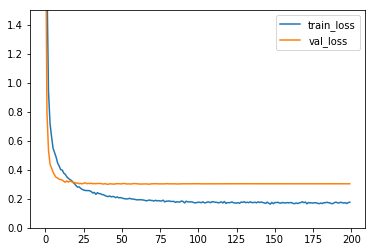

In [51]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()
plt.ylim([0,1.5])

In [52]:
out_softmax = nd.softmax(net(nd.array(X_test_resnet152_v2).as_in_context(ctx)))

synsets = mx.gluon.data.vision.ImageFolderDataset("/Users/shengwan/Desktop/data/train_gy").synsets
ids = sorted(os.listdir("/Users/shengwan/Desktop/data/test_gy/0/"))
ids = [i[:-4] for i in ids]

df = pd.DataFrame(out_softmax.asnumpy())
df.columns = synsets
df["id"] = ids
df = df[["id"]+synsets]
df.to_csv('/Users/shengwan/Desktop/data/pred-resnet152_v2.csv', index=None)